Preparing "worst" and "best" subsets per category in dataset bases on hash distance metrics

In [1]:
import numpy as np
#see create_training_paths for creation of the precalculated dcts; 
#due to copyright these may present an issue when uploaded/clash with the open license -> you have to repeat the script yourself
cifar10_hashes = np.load('cifar10_hashes.npz')

In [2]:
hashes, paths = cifar10_hashes['hashes'], cifar10_hashes['paths']

In [3]:
from cifar10_trainer import get_cat
idx = {}
for i,p in enumerate(paths[10000:]):
    idx.setdefault(get_cat(p),[]).append(i+10000)
idx = {k:[min(v),max(v)] for k,v in idx.items()}

In [82]:
bit_counts = np.array([int(bin(x).count("1")) for x in range(256)]).astype(np.uint8)
def hamming_dist(a,b,axis=None):
    return np.sum(bit_counts[np.bitwise_xor(a,b)],axis=axis)
def hex2hash(s):
    return np.frombuffer(bytes.fromhex(s), dtype=np.uint8)
def hash2hex(h):
    return h.tobytes().hex()
def calc_inter_dist(hashes, eye_val=1024):
    all_d = np.zeros((hashes.shape[0],hashes.shape[0]),dtype=np.int32)
    for i in range(hashes.shape[0]):
        all_d[i,i+1:] = hamming_dist(hashes[i],hashes[(i+1):], axis=1)
    return all_d+all_d.T+np.eye(hashes.shape[0],dtype=np.int32)*eye_val

In [148]:
def get_best_indices(hashes, reverse = False, remove_transp = True, add_neigh = 0, eye_val=1024):
    sorted_idx, fixed_idx = [], set()
    deactivate_val = max(hashes[0][0],1024) if reverse else 0
    dists32 = calc_inter_dist(hashes, deactivate_val)
    dists_sqr = dists32*dists32
    deactivate_val_sqr = deactivate_val*deactivate_val
    while len(sorted_idx) < hashes.shape[0]-1:
        dists_rows = np.sum(dists_sqr, axis = 0)
        if reverse:
            idx0 = np.argmin(dists_rows) #this row has the smallest overall distances
        else:
            idx0 = np.argmax(dists_rows) #this row has the largest overall distances
        sorted_idx.append(idx0)
        fixed_idx.add(idx0)
        #also add "best" neighbors
        if add_neigh > 0:
            neighbors = np.argsort(dists32[idx0,:])
            if not reverse:
                neighbors = neighbors[::-1]
            for i in range(add_neigh):
                idx1 = neighbors[i]
                if idx1 in fixed_idx:
                    continue
                sorted_idx.append(idx1)
                fixed_idx.add(idx1)
                dists_sqr[:,idx1] = deactivate_val_sqr
                if remove_transp:
                    dists_sqr[idx1,:] = deactivate_val_sqr
        #deactivate added index
        dists_sqr[:,idx0] = deactivate_val_sqr
        if remove_transp:
            dists_sqr[idx0,:] = deactivate_val_sqr
    if len(sorted_idx) < hashes.shape[0]:
        last_idx = list(set(range(hashes.shape[0])).difference(fixed_idx))[0]
        sorted_idx.append(last_idx)
    return sorted_idx

def get_minimal_sets(hashes, idx, reverse = False, remove_transp = True, add_neigh = 0):
    ret_sets = {}
    for k,idx_m in idx.items():
        ret_sets[k] = [i+idx_m[0] for i in get_best_indices(hashes[idx_m[0]:idx_m[1]], reverse=reverse, remove_transp=remove_transp, add_neigh=add_neigh)]
    return ret_sets

hash_sets = {}
for remove_transp in [True, False]:
    name0 = 'set_' if remove_transp else 'twi_'
    for reverse in [True, False]:
        name1 = name0 + ('w' if reverse else 'b')
        for add_neigh in [0, 1, 2]:
            hash_sets[name1+'%i'%add_neigh] = get_minimal_sets(hashes, idx, reverse = reverse, remove_transp = remove_transp, add_neigh = add_neigh)


In [151]:
hash_sets_int ={k0:{k1:[int(i) for i in v1] for k1,v1 in v0.items()} for k0,v0 in hash_sets.items()}

In [184]:
def get_rand_seq(idx):
    retseq = {}
    for k, v in idx.items():
        l0 = list(range(v[0],v[1]))
        np.random.shuffle(l0)
        retseq[k] = np.int32(l0).tolist()
    return retseq
randsets = {'r%i'%i:get_rand_seq(idx) for i in range(10)}

In [154]:
def check_complete(set0, idx):
    for k,v in idx.items():
        s0 = set(set0[k])
        s1 = set(range(v[0],v[1]))
        if len(s0) == len(s1) and len(s0.difference(s1)) == 0:
            continue
        m0, m1 = list(s1.difference(s0)), list(s0.difference(s1))
        print(k, "missing:", m0[:4], len(m0), m1[:4], len(m1))
for k,v in hash_sets_int.items():
    print(k)
    check_complete(v, idx)

set_w0
set_w1
set_w2
set_b0
set_b1
set_b2
twi_w0
twi_w1
twi_w2
twi_b0
twi_b1
twi_b2


In [188]:
def unify_name(n):
    return n.replace('set_w','w').replace('set_b','b').replace('twi_w','W').replace('twi_b','B')
hash_sets = {unify_name(k):{k1:np.int32(v1).tolist() for k1,v1 in v.items()} for k,v in hash_sets_int.items()}
hash_sets.update(randsets)

In [166]:
all_c = list(hash_sets_int.keys())
for i in range(len(all_c)):
    s0 = hash_sets_int[all_c[i]]
    for j in range(i+1,len(all_c)):
        s1 = hash_sets_int[all_c[j]]
        for k in s1.keys():
            if np.all(np.asarray(s0[k]) == np.asarray(s1[k])):
                print(all_c[i], all_c[j], k)

In [190]:
hash_sets['paths'] = paths.tolist()
import json
json.dump(hash_sets, open('cifar10_hashsets.json','wt'))

In [191]:
!gzip cifar10_hashsets.json

w0


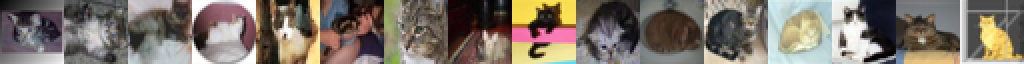

w1


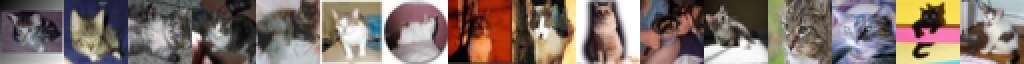

w2


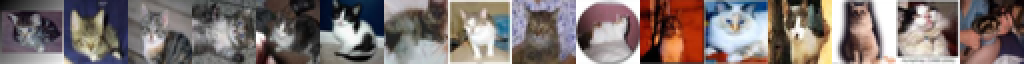

b0


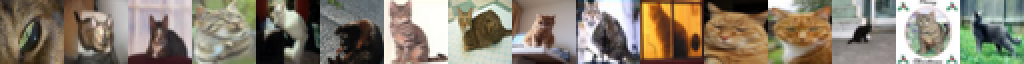

b1


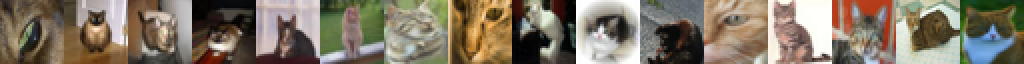

b2


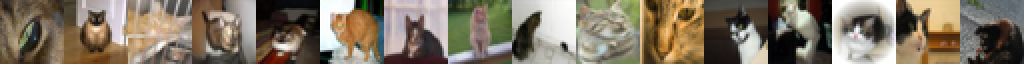

W0


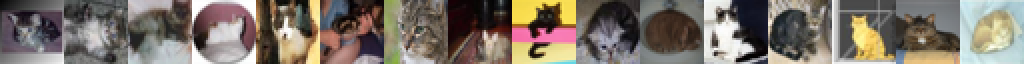

W1


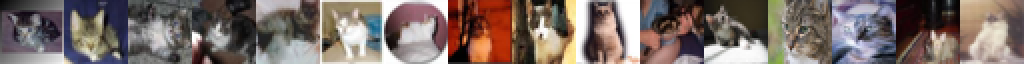

W2


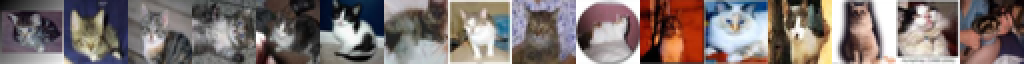

B0


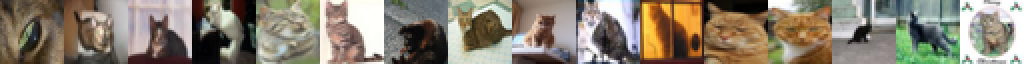

B1


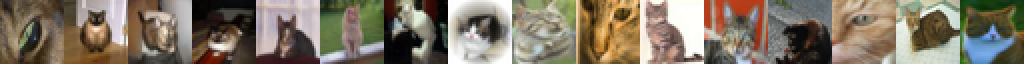

B2


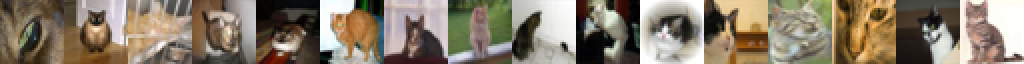

r0


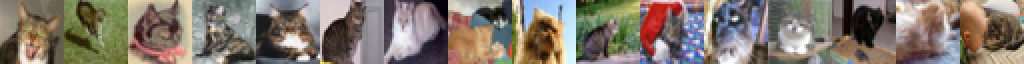

r1


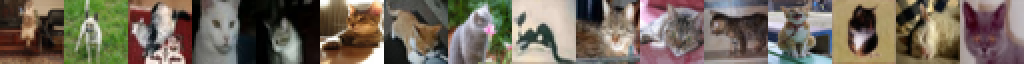

r2


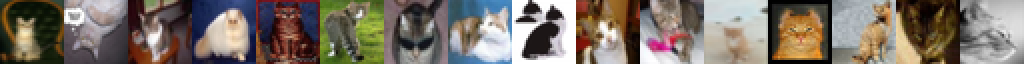

r3


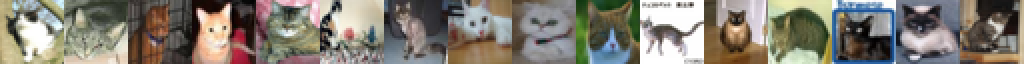

r4


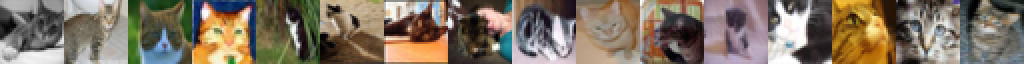

r5


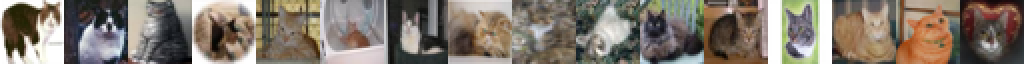

r6


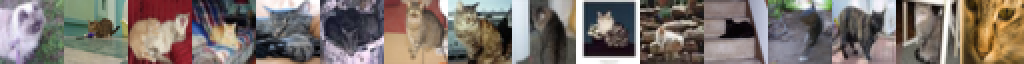

r7


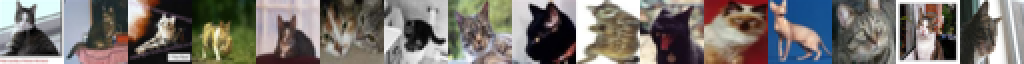

r8


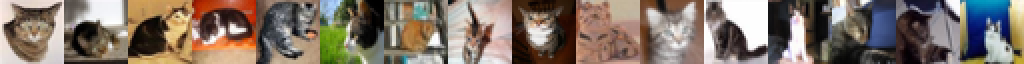

r9


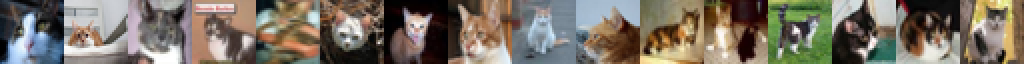

In [194]:
from PIL import Image as pi
from IPython import display as disp0
import numpy as np
import cv2
def show_im(img, is_bgr=True):
    if is_bgr and len(img.shape) > 2 and img.shape[2] == 3:
        img = img[...,::-1] #PIL needs RGB instead of opencv's BGR
    if img.dtype != np.uint8:
        img = (img * (255.499/np.max(img))).astype(np.uint8)  #automatically change HDR range to LDR
    show_impil(pi.fromarray(img))
def show_impil(img):
    disp0.display(img)
def vis_cifar(ids, paths, max_num = 16, fx=2.0):
    ims = [cv2.resize(cv2.imread(paths[i]),(0,0),fx=fx,fy=fx,interpolation=cv2.INTER_NEAREST) for i in ids[:max_num]]
    show_im(np.hstack(ims))
for k,v in hash_sets.items():
    if k == 'paths':
        continue
    print(k)
    vis_cifar(v['cat'], paths)

w0


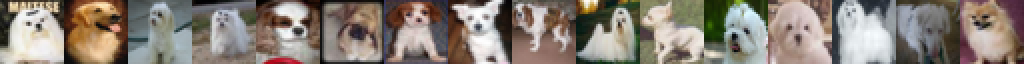

w1


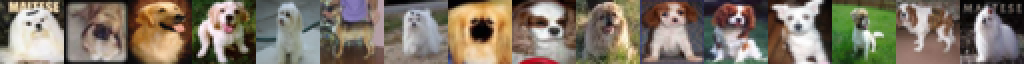

w2


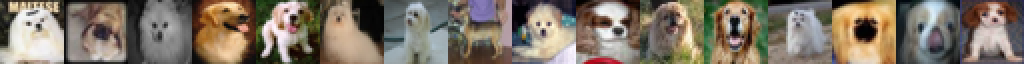

b0


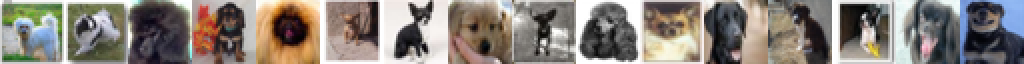

b1


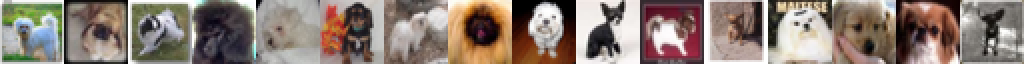

b2


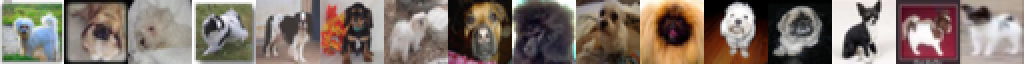

W0


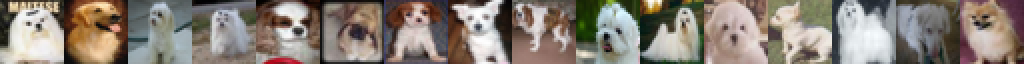

W1


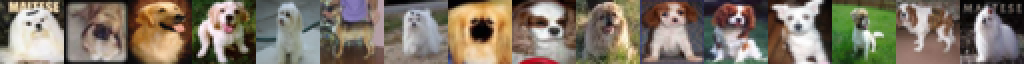

W2


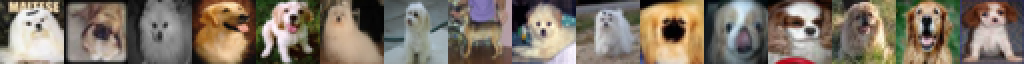

B0


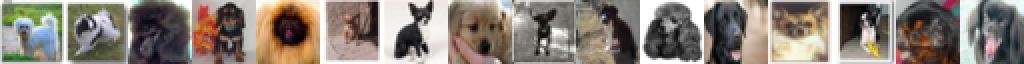

B1


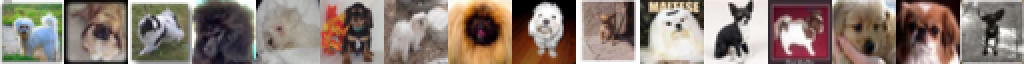

B2


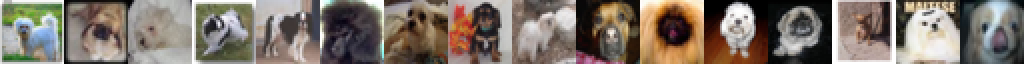

r0


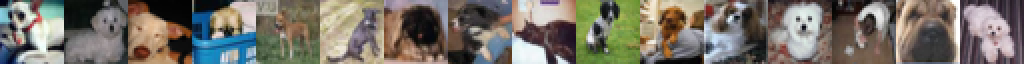

r1


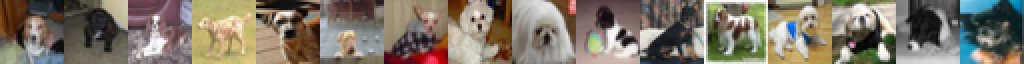

r2


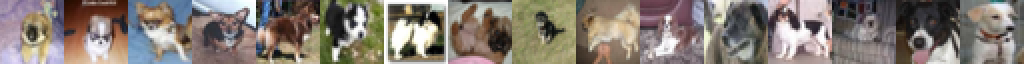

r3


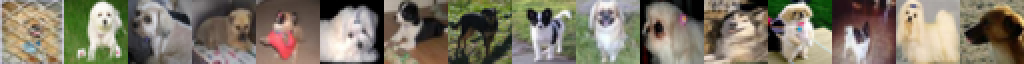

r4


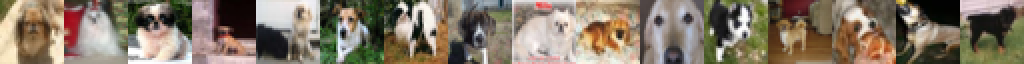

r5


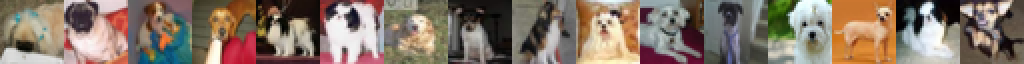

r6


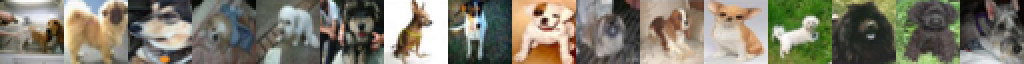

r7


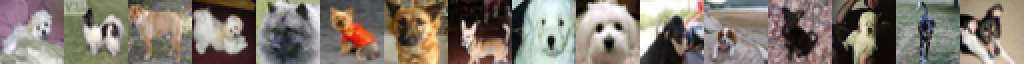

r8


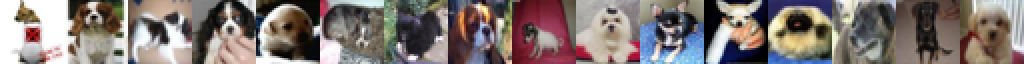

r9


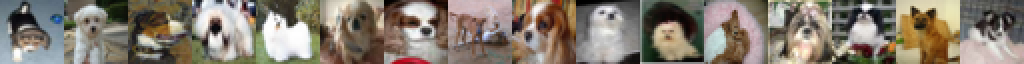

In [195]:
for k,v in hash_sets.items():
    if k == 'paths':
        continue
    print(k)
    vis_cifar(v['dog'], paths)